# Reproducibility

In [100]:
from repro_eval.Evaluator import RpdEvaluator, RplEvaluator
from repro_eval.util import arp, arp_scores, print_base_adv, print_simple_line, trim

import pytrec_eval
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
colors = sns.color_palette()
sns.set_style('darkgrid')

In [101]:
core_queries = pd.read_csv("../data/core_queries.tsv", sep="\t")
core_docs = pd.read_csv("../data/core_docs.tsv", sep="\t")

In [102]:
core_queries2 = pd.read_csv("../data/core_queries.tsv", sep="\t")
core_docs2 = pd.read_csv("../data/core_docs.tsv", sep="\t")

In [103]:
def harmonize_run(run_path, t, name):      
    if type(run_path) == str:
        df = pd.read_csv(run_path, sep=" ", header=None, names=["qid", "Q0", "docno", "rank", "rel", "name"])
    else:
        df = run_path

    # Limit to core queries
    df = df[df["qid"].isin(core_queries["qid_"+t])]
    
    # Rename to WT
    patch_query = {}
    for _, row in core_queries.iterrows():
        patch_query[row["qid_"+t]] = row["qid_WT"]

    df["qid"] = df["qid"].apply(lambda x: patch_query[x])
    
    print("duplicates", df.duplicated(subset=["qid", "docno"]).sum())
    df.drop_duplicates(subset=["qid", "docno"], inplace=True)

    num = len(df["qid"].unique())
    print(t, num, "queries in qrels")

    # Limit to core docs
    df = df[df["docno"].isin(core_docs["docno_"+t])]

    patch_doc = {}
    for _, row in core_docs.iterrows():
        patch_doc[row["docno_"+t]] = row["docno_WT"]

    def rename(x):
        new_id = patch_doc.get(x)
        if not new_id:
            return x
        else:
            return new_id


    # Rename docs to WT
    df["docno"] = df["docno"].apply(rename)

    # Rename run name
    df["name"] = name
    df.to_csv("../data/reproducibility/"+name, sep=" ", header=None, index=False)

In [104]:
def harmonize_qrels(qrels_path, t):           
    if type(qrels_path) == str:
        df = pd.read_csv(qrels_path, sep=" ", header=None, names=["qid", "Q0", "docno", "rel", "name"])
    else:
        df = qrels_path
        
    # limit to core queries
    df = df[df["qid"].isin(core_queries["qid_"+t])]

    # rename core queries to WT ID
    patch_query = {}
    for _, row in core_queries.iterrows():
        patch_query[row["qid_"+t]] = row["qid_WT"]

    df["qid"] = df["qid"].apply(lambda x: patch_query[x])
    num = len(df["qid"].unique())
    print(t, num, "queries in qrels")

    print("duplicates", df.duplicated(subset=["qid", "docno"]).sum())
    df.drop_duplicates(subset=["qid", "docno"], inplace=True)

    # limit to core docs
    df = df[df["docno"].isin(core_docs["docno_"+t])]

    # rename core docs to WT ID
    patch_docs = {}
    for _, row in core_docs.iterrows():
        patch_docs[row["docno_"+t]] = row["docno_WT"]

    def rename(x):
        new_id = patch_docs.get(x)
        if not new_id:
            return x
        else:
            return new_id
        
    df["docno"] = df["docno"].apply(rename)


    df.to_csv(f"../data/reproducibility/qrels_{t}.txt", sep=" ", header=None, index=False)

In [105]:
runs = {
    "WT": {"runs":{
        "E5": {"path": "../data/reproducibility/IRC_E5_base.WT"},
        "colBERT": {"path": "../data/reproducibility/IRC_BM25+colBERT.WT"},
        "monoT5": {"path": "../data/reproducibility/IRC_BM25+monoT5.WT"},
        "d2q": {"path": "../data/reproducibility/IRC_d2q+BM25.WT"},
        "RRF": {"path": "../data/reproducibility/IRC_RRF(BM25+Bo1-XSqrA_M-PL2).WT"},
    }, 
        "qrel": {"path": "../data/reproducibility/qrels_WT.txt"},
        "pivot": {"path": "../data/reproducibility/IRC_BM25.WT"},
        },
    "ST": {"runs":{
        "E5": {"path": "../data/reproducibility/IRC_E5_base.ST"},
        "colBERT": {"path": "../data/reproducibility/IRC_BM25+colBERT.ST"},
        "monoT5": {"path": "../data/reproducibility/IRC_BM25+monoT5.ST"},
        "d2q": {"path": "../data/reproducibility/IRC_d2q+BM25.ST"},
        "RRF": {"path": "../data/reproducibility/IRC_RRF(BM25+Bo1-XSqrA_M-PL2).ST"},
    }, 
        "qrel": {"path": "../data/reproducibility/qrels_ST.txt"},
        "pivot": {"path": "../data/reproducibility/IRC_BM25.ST"},
    },
    "LT": {"runs":{
        "E5": {"path": "../data/reproducibility/IRC_E5_base.LT"},
        "colBERT": {"path": "../data/reproducibility/IRC_BM25+colBERT.LT"},
        "monoT5": {"path": "../data/reproducibility/IRC_BM25+monoT5.LT"},
        "d2q": {"path": "../data/reproducibility/IRC_d2q+BM25.LT"},
        "RRF": {"path": "../data/reproducibility/IRC_RRF(BM25+Bo1-XSqrA_M-PL2).LT"},
    },
        "qrel": {"path": "../data/reproducibility/qrels_LT.txt"},
        "pivot": {"path": "../data/reproducibility/IRC_BM25.LT"},
    }
}

## Baseline
run_BM25_train_WT = "../results/train/IRC_BM25.WT"
run_BM25_test_WT = "../results/test/IRC_BM25.WT"
run_BM25_ST = "../results/test/IRC_BM25.ST"
run_BM25_LT = "../results/test/IRC_BM25.LT"

## Advanced
run_E5_train_WT = "../results/train/IRC_E5_base.WT-train"
run_E5_test_WT = "../results/test/IRC_E5_base.WT"
run_E5_ST = "../results/test/IRC_E5_base.ST"
run_E5_LT = "../results/test/IRC_E5_base.LT"

run_colbert_test_WT = "../results/test/IRC_BM25+colBERT.WT"
run_colbert_train_WT = "../results/train/IRC_BM25+colBERT.WT"
run_colbert_ST = "../results/test/IRC_BM25+colBERT.ST"
run_colbert_LT = "../results/test/IRC_BM25+colBERT.LT"

run_monoT5_test_WT = "../results/test/IRC_BM25+monoT5.WT"
run_monoT5_train_WT = "../results/train/IRC_BM25+monoT5.WT"
run_monoT5_ST = "../results/test/IRC_BM25+monoT5.ST"
run_monoT5_LT = "../results/test/IRC_BM25+monoT5.LT"

run_d2q_test_WT = "../results/test/IRC_d2q+BM25.WT"
run_d2q_train_WT = "../results/train/IRC_d2q+BM25.WT"
run_d2q_ST = "../results/test/IRC_d2q+BM25.ST"
rub_d2q_LT = "../results/test/IRC_d2q+BM25.LT"

run_RRF_test_WT = "../results/test/IRC_RRF(BM25+Bo1-XSqrA_M-PL2).WT"
run_RRF_train_WT = "../results/train/IRC_RRF(BM25+Bo1-XSqrA_M-PL2).WT"
run_RRF_ST = "../results/test/IRC_RRF(BM25+Bo1-XSqrA_M-PL2).ST"
run_RRF_LT = "../results/test/IRC_RRF(BM25+Bo1-XSqrA_M-PL2).LT"

# queries
queries_WT_path = "../data/publish/English/Queries/heldout.trec"
queries_ST_path = "../data/test-collection/A-Short-July/English/Queries/test07.trec"
queries_LT_path = "../data/test-collection/B-Long-September/English/Queries/test09.trec"

# qrels
qrels_WT_test_path = "../data/longeval-relevance-judgements/heldout-test.txt"
qrels_WT_train_path = "../data/publish/French/Qrels/train.txt"
qrels_ST_path = "../data/longeval-relevance-judgements/a-short-july.txt"
qrels_LT_path = "../data/longeval-relevance-judgements/b-long-september.txt"

In [106]:
# df_test = pd.read_csv(run_BM25_train_WT, sep=" ", header=None, names=["qid", "Q0", "docno", "rank", "rel", "name"])
# df_train = pd.read_csv(run_BM25_test_WT, sep=" ", header=None, names=["qid", "Q0", "docno", "rank", "rel", "name"])
# run_BM25 = pd.concat([df_test, df_train])
# harmonize_run(run_BM25, "WT", "IRC_BM25.WT")
# harmonize_run(run_BM25_ST, "ST", "IRC_BM25.ST")
# harmonize_run(run_BM25_LT, "LT", "IRC_BM25.LT")

# df_test = pd.read_csv(run_E5_train_WT, sep=" ", header=None, names=["qid", "Q0", "docno", "rank", "rel", "name"])
# df_train = pd.read_csv(run_E5_test_WT, sep=" ", header=None, names=["qid", "Q0", "docno", "rank", "rel", "name"])
# run_E5 = pd.concat([df_test, df_train])
# harmonize_run(run_E5, "WT", "IRC_E5_base.WT")
# harmonize_run(run_E5_ST, "ST", "IRC_E5_base.ST")
# harmonize_run(run_E5_LT, "LT", "IRC_E5_base.LT")

# df_test = pd.read_csv(run_colbert_train_WT, sep=" ", header=None, names=["qid", "Q0", "docno", "rank", "rel", "name"])
# df_train = pd.read_csv(run_colbert_test_WT, sep=" ", header=None, names=["qid", "Q0", "docno", "rank", "rel", "name"])
# run_colbert = pd.concat([df_test, df_train])
# harmonize_run(run_colbert, "WT", "IRC_BM25+colBERT.WT")
# harmonize_run(run_colbert_ST, "ST", "IRC_BM25+colBERT.ST")
# harmonize_run(run_colbert_LT, "LT", "IRC_BM25+colBERT.LT")

# df_test = pd.read_csv(run_monoT5_train_WT, sep=" ", header=None, names=["qid", "Q0", "docno", "rank", "rel", "name"])
# df_train = pd.read_csv(run_monoT5_test_WT, sep=" ", header=None, names=["qid", "Q0", "docno", "rank", "rel", "name"])
# run_monoT5 = pd.concat([df_test, df_train])
# harmonize_run(run_monoT5, "WT", "IRC_BM25+monoT5.WT")
# harmonize_run(run_monoT5_ST, "ST", "IRC_BM25+monoT5.ST")
# harmonize_run(run_monoT5_LT, "LT", "IRC_BM25+monoT5.LT")

# df_test = pd.read_csv(run_d2q_train_WT, sep=" ", header=None, names=["qid", "Q0", "docno", "rank", "rel", "name"])
# df_train = pd.read_csv(run_d2q_test_WT, sep=" ", header=None, names=["qid", "Q0", "docno", "rank", "rel", "name"])
# run_d2q = pd.concat([df_test, df_train])
# harmonize_run(run_d2q, "WT", "IRC_d2q+BM25.WT")
# harmonize_run(run_d2q_ST, "ST", "IRC_d2q+BM25.ST")
# harmonize_run(rub_d2q_LT, "LT", "IRC_d2q+BM25.LT")

# df_test = pd.read_csv(run_RRF_train_WT, sep=" ", header=None, names=["qid", "Q0", "docno", "rank", "rel", "name"])
# df_train = pd.read_csv(run_RRF_test_WT, sep=" ", header=None, names=["qid", "Q0", "docno", "rank", "rel", "name"])
# run_RRF = pd.concat([df_test, df_train])
# harmonize_run(run_RRF, "WT", "IRC_RRF(BM25+Bo1-XSqrA_M-PL2).WT")
# harmonize_run(run_RRF_ST, "ST", "IRC_RRF(BM25+Bo1-XSqrA_M-PL2).ST")
# harmonize_run(run_RRF_LT, "LT", "IRC_RRF(BM25+Bo1-XSqrA_M-PL2).LT")

In [107]:
# df_test = pd.read_csv(qrels_WT_test_path, sep=" ", header=None, names=["qid", "Q0", "docno", "rel"])
# df_train = pd.read_csv(qrels_WT_train_path, sep=" ", header=None, names=["qid", "Q0", "docno", "rel"])
# qrels_WT = pd.concat([df_test, df_train])

# harmonize_qrels(qrels_WT, "WT")
# harmonize_qrels(qrels_ST_path, "ST")
# harmonize_qrels(qrels_LT_path, "LT")

# ARP

In [108]:
for subcollection , content in runs.items(): 
    with open(content.get('qrel').get('path'), "r") as f_qrels:
        qrels = pytrec_eval.parse_qrel(f_qrels)
    evaluator = pytrec_eval.RelevanceEvaluator(qrels, pytrec_eval.supported_measures)

    for run_name, info in content["runs"].items():
        with open(info.get('path')) as run_file:
            info['run'] = pytrec_eval.parse_run(run_file)
            info["score"] = evaluator.evaluate(info.get('run'))
            info["arp"] = arp_scores(info.get('score'))
    
    baseline = content.get('pivot').get('path')
    content["pivot"]["run"] = pytrec_eval.parse_run(open(baseline))
    content["pivot"]["score"] = evaluator.evaluate(content["pivot"]["run"])
    content["pivot"]["arp"] = arp_scores(content["pivot"]["score"])

In [109]:
q = open(runs["ST"]["qrel"]["path"], "r")
qrels = pytrec_eval.parse_qrel(q)

In [110]:
evaluator = pytrec_eval.RelevanceEvaluator(qrels, pytrec_eval.supported_measures)

In [112]:
table = []
measures=['P_20', 'ndcg', 'bpref']

for subcollection , content in runs.items(): 
    for run_name, info in content["runs"].items():
        for measure in measures:
            table.append(
                {"sub-collection": subcollection, "run": run_name, "measure": measure, "value": info.get('arp').get(measure)}
            )
    for measure in measures:
        table.append(
            {"sub-collection": subcollection, "run": "baseline", "measure": measure, "value": content.get('pivot').get('arp').get(measure)}
        )
        
result_table = pd.DataFrame(table).pivot(index=["measure", "run"], columns="sub-collection", values="value")[["WT", "ST", "LT"]]

# $\mathcal{R}_e\Delta$

In [113]:
result_table["RD(WT, ST)"] = result_table["WT"] - result_table["ST"]
result_table["RD(WT, LT)"] = result_table["WT"] - result_table["LT"]

# Delta Plots

In [114]:
for subcollection, content in runs.items(): 
    for run_name, info in content["runs"].items():
        deltas = {}
        for topic, results in info["score"].items():
            deltas[topic] = results["ndcg"] - content["pivot"]["score"][topic]["ndcg"]
        info["topic_delta"] = deltas

In [115]:
pl = []
for topic in runs["WT"]["runs"]["RRF"]["score"].keys():
    try:
        pl.append((topic,
                  runs["WT"]["runs"]["RRF"]["score"][topic]["ndcg"],   
                  runs["ST"]["runs"]["RRF"]["score"][topic]["ndcg"],
                  runs["LT"]["runs"]["RRF"]["score"][topic]["ndcg"])), 
    except:
        print(topic)
rrf = pd.DataFrame(pl, columns=["topic", "WT", "ST", "LT"])[["WT", "ST", "LT"]]
rrf["task1"] = rrf["WT"] - rrf["ST"]
rrf["task2"] = rrf["WT"] - rrf["LT"]

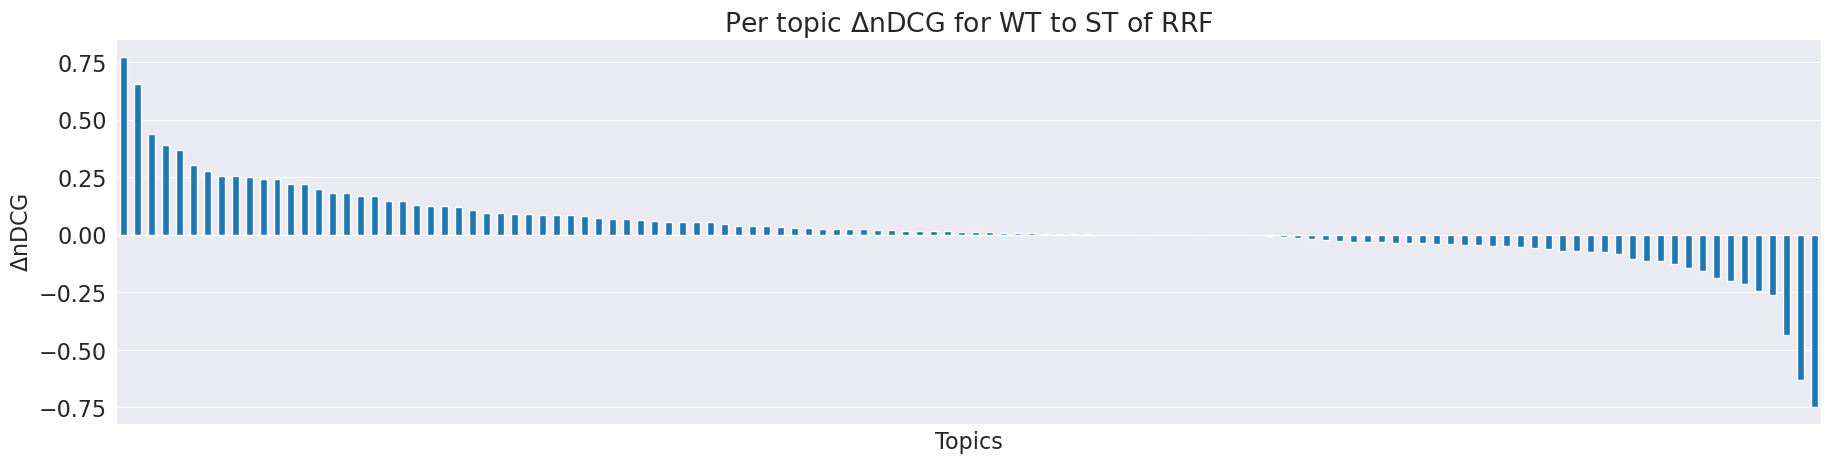

In [116]:
sns.set_palette("tab10")
plt.rcParams.update({'font.size': 16})
ax = rrf.sort_values(by="task1", ascending=False)["task1"].sort_values(ascending=False).plot(
    kind="bar", 
    figsize=(22, 5), 
    title="RRF nDCG per topic and sub-collection",
    ylabel="nDCG",
    xlabel="Topic")

ax.set_xlabel("Topics")
ax.set_ylabel('$\Delta$nDCG')
plt.xticks([])
plt.title("Per topic $\Delta$nDCG for WT to ST of RRF")
plt.show()

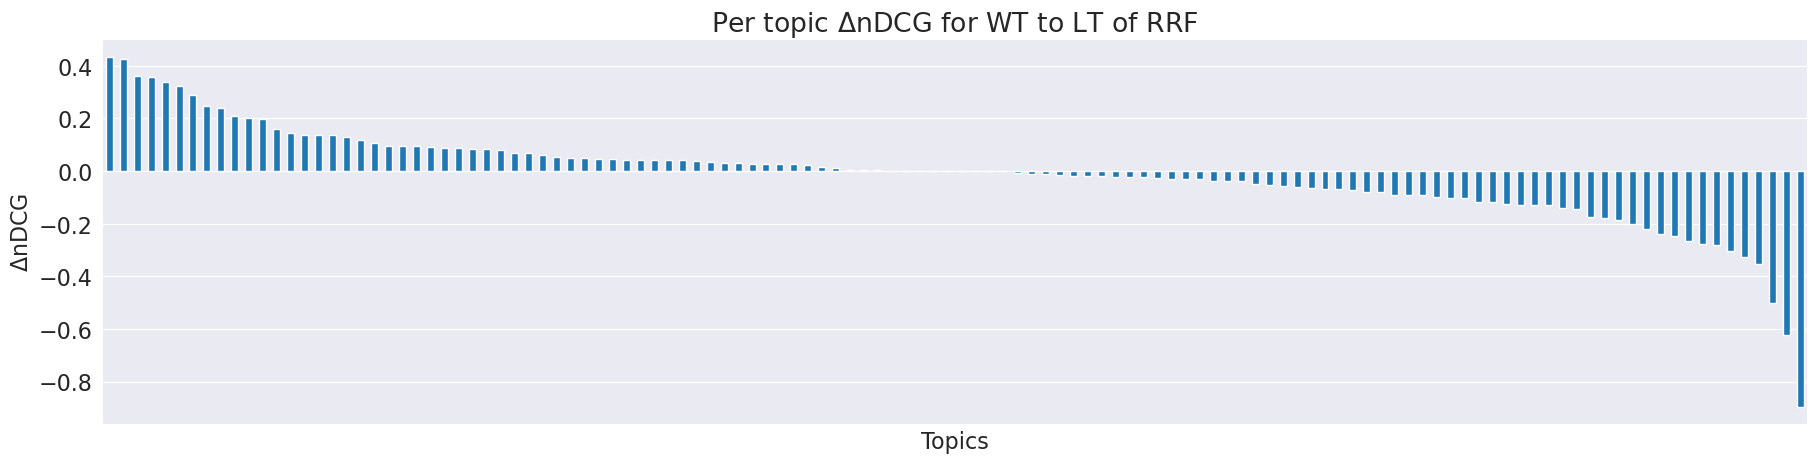

In [117]:
sns.set_palette("tab10")
plt.rcParams.update({'font.size': 16})

ax = rrf["task2"].sort_values(ascending=False).plot(
    kind="bar", 
    figsize=(22, 5), 
    title="RRF nDCG per topic and sub-collection",
    ylabel="nDCG",
    xlabel="Topic")

ax.set_xlabel("Topics")
ax.set_ylabel('$\Delta$nDCG')

plt.xticks([])
plt.title("Per topic $\Delta$nDCG for WT to LT of RRF")
plt.show()

# Replicability

### ER-DRI

In [118]:
dri_er_WTST = {}

# Evaluate all runs 
for WT, ST in zip(runs["WT"]["runs"].items(), runs["ST"]["runs"].items()):
    rpl_eval = RplEvaluator(qrel_orig_path=runs["WT"]["qrel"]["path"],
                            run_b_orig_path=runs["WT"]["pivot"]["path"],
                            run_a_orig_path=WT[1]["path"],
                            run_b_rep_path=runs["ST"]["pivot"]["path"],
                            run_a_rep_path=ST[1]["path"],
                            qrel_rpl_path=runs["ST"]["qrel"]["path"])

    rpl_eval.trim()
    rpl_eval.evaluate()

    # save dri, er and pval
    runs["ST"]["runs"][WT[0]]["dri"] = rpl_eval.dri()
    runs["ST"]["runs"][WT[0]]["er"] = rpl_eval.er()
    runs["ST"]["runs"][WT[0]]["pval"] = rpl_eval.ttest()

    dri_er_WTST[WT[0]] = {"dri": rpl_eval.dri(), "er": rpl_eval.er()}

/home/jueri/miniconda3/envs/LongEval/lib/python3.8/site-packages/repro_eval/measure/overall_effects.py:82: RuntimeWarning: invalid value encountered in double_scalars
  yield measure, value / mi_orig.get(measure)
/home/jueri/miniconda3/envs/LongEval/lib/python3.8/site-packages/repro_eval/measure/overall_effects.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  yield measure, value / mi_orig.get(measure)


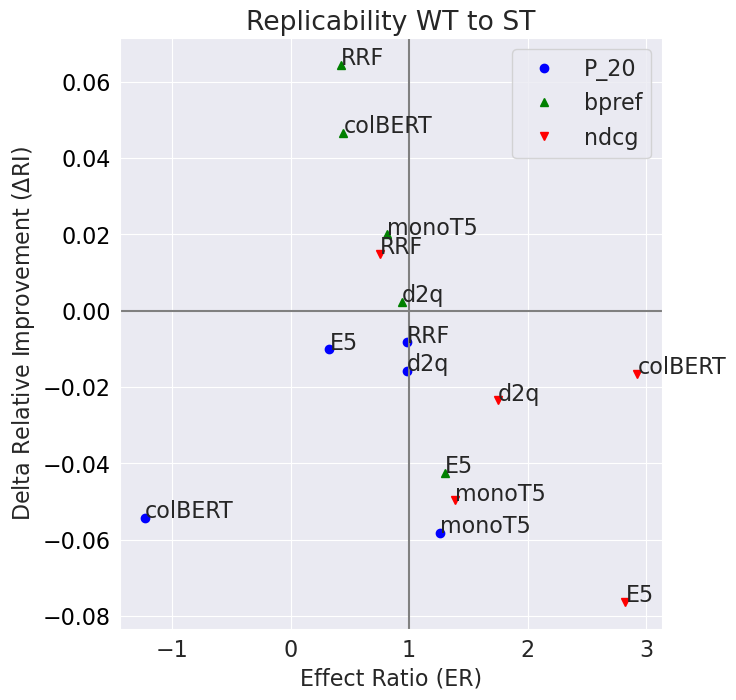

In [119]:
measures = ['P_20', 'bpref', 'ndcg']
marker_color = [('o', 'b'), ('^', 'g'), ('v', 'r')]

fig, ax1 = plt.subplots(figsize=(7, 7))
ax1.set_xlabel('Effect Ratio (ER)')
ax1.set_ylabel(u'Delta Relative Improvement ($\Delta$RI)')

for measure, mk in zip(measures, marker_color):
    ax1.plot([dri_er_WTST[r]['er'][measure] for r in dri_er_WTST.keys()],
             [dri_er_WTST[r]['dri'][measure] for r in dri_er_WTST.keys()],
             marker=mk[0], color=mk[1], linestyle='None', label=measure)

ax1.tick_params(axis='y', labelcolor='k')
fig.tight_layout()
plt.axhline(0, color='grey')
plt.axvline(1, color='grey')
plt.legend()
plt.title('Replicability WT to ST')

for m in measures:
  for r in dri_er_WTST.keys():
    plt.text(x = dri_er_WTST[r]['er'][m], 
             y = dri_er_WTST[r]['dri'][m],
             s = r) 

plt.show()

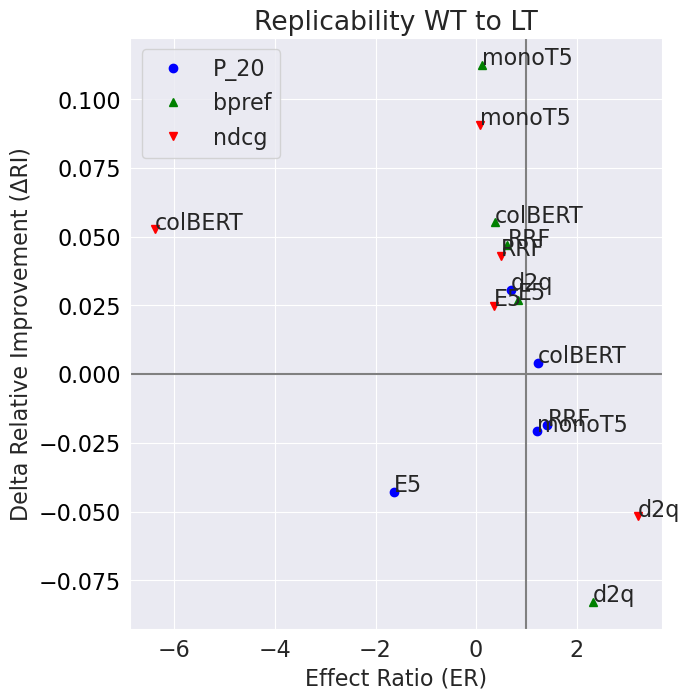

In [120]:
dri_er_WTLT = {}

for WT, LT in zip(runs["WT"]["runs"].items(), runs["LT"]["runs"].items()):
    # evaluate run
    # if WT[0].endswith("E5"):
    #     continue
    rpl_eval = RplEvaluator(qrel_orig_path=runs["WT"]["qrel"]["path"],
                            run_b_orig_path=runs["WT"]["pivot"]["path"],
                            run_a_orig_path=WT[1]["path"],
                            run_b_rep_path=runs["LT"]["pivot"]["path"],
                            run_a_rep_path=LT[1]["path"],
                            qrel_rpl_path=runs["LT"]["qrel"]["path"])

    rpl_eval.trim()
    rpl_eval.evaluate()

    # save dri, er and pval
    runs["LT"]["runs"][WT[0]]["dri"] = rpl_eval.dri()
    runs["LT"]["runs"][WT[0]]["er"] = rpl_eval.er()
    runs["LT"]["runs"][WT[0]]["pval"] = rpl_eval.ttest()

    dri_er_WTLT[WT[0]] = {"dri": rpl_eval.dri(), "er": rpl_eval.er()}


measures = ['P_20', 'bpref', 'ndcg']
marker_color = [('o', 'b'), ('^', 'g'), ('v', 'r')]

fig, ax1 = plt.subplots(figsize=(7, 7))
ax1.set_xlabel('Effect Ratio (ER)')
ax1.set_ylabel(u'Delta Relative Improvement (ΔRI)')

for measure, mk in zip(measures, marker_color):
    ax1.plot([dri_er_WTLT[r]['er'][measure] for r in dri_er_WTLT.keys()],
             [dri_er_WTLT[r]['dri'][measure] for r in dri_er_WTLT.keys()],
             marker=mk[0], color=mk[1], linestyle='None', label=measure)

ax1.tick_params(axis='y', labelcolor='k')
fig.tight_layout()
plt.axhline(0, color='grey')
plt.axvline(1, color='grey')
plt.legend()
plt.title('Replicability WT to LT')

for m in measures:
  for r in dri_er_WTST.keys():
    plt.text(x = dri_er_WTLT[r]['er'][m], 
             y = dri_er_WTLT[r]['dri'][m],
             s = r) 

plt.show()

### ER, DRI, p-test

In [121]:
table = []
measures=['P_20', 'ndcg', 'bpref']

for subcollection , content in runs.items(): 
    for run_name, info in content["runs"].items():
        for measure in measures:
            table.append(
                {"sub-collection": subcollection, 
                 "run": run_name, 
                 "measure": measure, 
                 "value": info.get('arp').get(measure)}
                )
            if info.get('dri'):
                table.append(
                    {"sub-collection": subcollection,
                    "run": run_name,
                    "measure": measure+"_dri",
                    "value": info.get('dri').get(measure)}
                )
            if info.get('er'):
                table.append(
                    {"sub-collection": subcollection,
                    "run": run_name,
                    "measure": measure+"_er",
                    "value": info.get('er').get(measure)}
                )
            if info.get('pval'):
                table.append(
                    {"sub-collection": subcollection,
                    "run": run_name,
                    "measure": measure+"_pval",
                    "value": info.get('pval').get("advanced").get(measure)}
                )


    for measure in measures:
        table.append(
            {"sub-collection": subcollection, "run": "baseline", "measure": measure, "value": content.get('pivot').get('arp').get(measure)}
        )    

# Reproducibility

In [122]:
shortest_ranking = []
for col in runs:
    for run in runs[col]["runs"]:
        minl = []
        for q in runs[col]["runs"][run]["run"].keys():
            shortest_ranking.append(len(runs[col]["runs"][run]["run"][q]))
print("Shortest run has", min(shortest_ranking), "documents ranked")    

Shortest run has 281 documents ranked


# RMSE
Relevance changes

In [145]:
from repro_eval.measure.effectiveness import rmse as RMSE

In [155]:
cutoffs = ['5', '10', '15', '20', '30', '100', '200', '500', '1000']

def rmse_cutoffs(b, a, cutoffs):
    res = []
    for cutoff in cutoffs:
        res.append(RMSE(b, a)[f"ndcg_cut_{cutoff}"])
    return res

In [167]:
df_content = {}
for WT, ST in zip(runs["WT"]["runs"].items(), runs["ST"]["runs"].items()):
    df_content[WT[0]] = rmse_cutoffs(WT[1]["score"], ST[1]["score"], cutoffs)
df_content["BM25"] = rmse_cutoffs(runs["WT"]["pivot"]["score"], runs["ST"]["pivot"]["score"], cutoffs)

<Figure size 640x480 with 0 Axes>

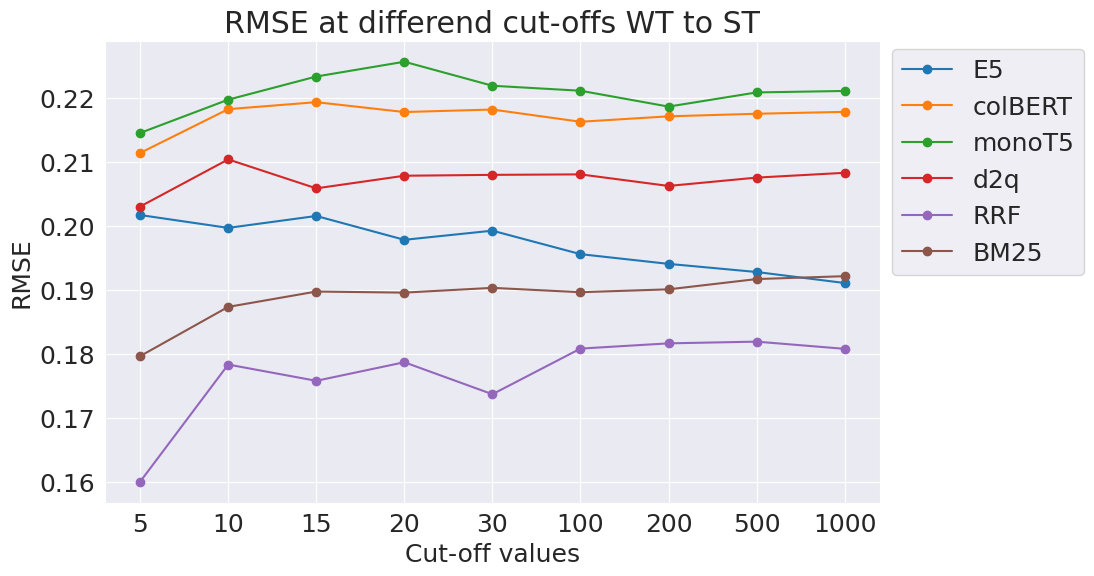

In [168]:
df = pd.DataFrame(df_content, index=cutoffs)
plt.figure()
plt.rcParams.update({'font.size': 18})
ax = df.plot.line(style='o-', figsize=(10, 6))
ax.set_title("RMSE at differend cut-offs WT to ST")
ax.set_xlabel('Cut-off values')
ax.set_ylabel('RMSE')
ax.legend(bbox_to_anchor=(1, 1.01))
plt.show()

# RMSE plot

In [172]:
for WT, ST in zip(runs["WT"]["runs"].items(), runs["ST"]["runs"].items()):
    rpd_eval = RpdEvaluator(qrel_orig_path=runs["WT"]["qrel"]["path"],
                            run_b_orig_path=runs["WT"]["pivot"]["path"],
                            run_a_orig_path=WT[1]["path"],
                            run_b_rep_path=runs["ST"]["pivot"]["path"],
                            run_a_rep_path=ST[1]["path"]
                            )
    
    rpd_eval.trim()
    rpd_eval.evaluate()

    # save resuls
    runs["ST"]["runs"][WT[0]]["pvals"] = rpd_eval.ttest()
    runs["ST"]["runs"][WT[0]]["dri"] = rpd_eval.dri()
    runs["ST"]["runs"][WT[0]]["er"] = rpd_eval.er()
    runs["ST"]["runs"][WT[0]]["rmse"] = rpd_eval.rmse()
    runs["ST"]["runs"][WT[0]]["rbo"] = rpd_eval.rbo()
    
    rpd_eval.trim(t=200)
    rpd_eval.evaluate()
    runs["ST"]["runs"][WT[0]]["ktau"] = rpd_eval.ktau_union()

/home/jueri/miniconda3/envs/LongEval/lib/python3.8/site-packages/repro_eval/measure/overall_effects.py:82: RuntimeWarning: invalid value encountered in double_scalars
  yield measure, value / mi_orig.get(measure)
/home/jueri/miniconda3/envs/LongEval/lib/python3.8/site-packages/repro_eval/measure/overall_effects.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  yield measure, value / mi_orig.get(measure)


In [173]:
cutoffs = ['5', '10', '15', '20', '30', '100', '200', '500', '1000']

df_content = {}
for run_name in runs["ST"]["runs"]:
    df_content[run_name] = [runs["ST"]["runs"][run_name]['rmse']['advanced']['ndcg_cut_' + co] for co in cutoffs]

df_content["baseline"] = [runs["ST"]["runs"][run_name]['rmse']['baseline']['ndcg_cut_' + co] for co in cutoffs]

<Figure size 640x480 with 0 Axes>

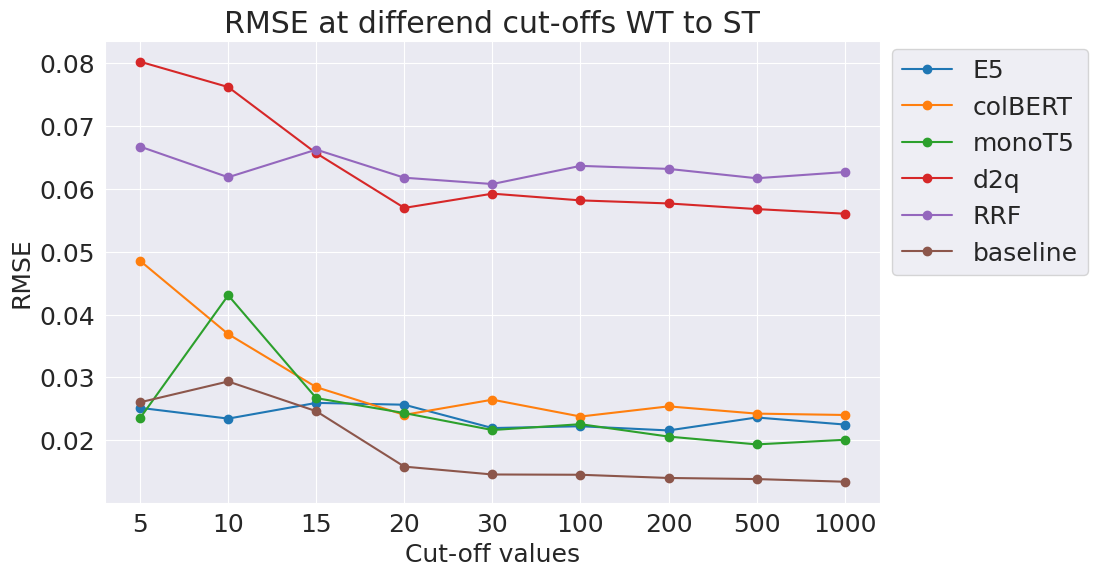

In [174]:
df = pd.DataFrame(df_content, index=[str(c) for c in cutoffs])
plt.figure()
plt.rcParams.update({'font.size': 18})
ax = df.plot.line(style='o-', figsize=(10, 6))
ax.set_title("RMSE of nDCG at differend cut-offs (WT to ST)")
ax.set_xlabel('Cut-off values')
ax.set_ylabel('RMSE')
ax.legend(bbox_to_anchor=(1, 1.01))
plt.show()
ax.figure.savefig("../../MA/text/images/RMSE_WT-ST.png", dpi=300, bbox_inches='tight')

In [175]:
for WT, LT in zip(runs["WT"]["runs"].items(), runs["LT"]["runs"].items()):
    rpd_eval = RpdEvaluator(qrel_orig_path=runs["WT"]["qrel"]["path"],
                            run_b_orig_path=runs["WT"]["pivot"]["path"],
                            run_a_orig_path=WT[1]["path"],
                            run_b_rep_path=runs["LT"]["pivot"]["path"],
                            run_a_rep_path=ST[1]["path"],
                            )
    
    rpd_eval.trim()
    rpd_eval.evaluate()

    # save resuls
    runs["LT"]["runs"][WT[0]]["pvals"] = rpd_eval.ttest()
    runs["LT"]["runs"][WT[0]]["dri"] = rpd_eval.dri()
    runs["LT"]["runs"][WT[0]]["er"] = rpd_eval.er()
    runs["LT"]["runs"][WT[0]]["rmse"] = rpd_eval.rmse()
    runs["LT"]["runs"][WT[0]]["rbo"] = rpd_eval.rbo()

    rpd_eval.trim(t=200)
    rpd_eval.evaluate()
    runs["LT"]["runs"][WT[0]]["ktau"] = rpd_eval.ktau_union()

/home/jueri/miniconda3/envs/LongEval/lib/python3.8/site-packages/repro_eval/measure/overall_effects.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  yield measure, value / mi_orig.get(measure)


In [176]:
cutoffs = ['5', '10', '15', '20', '30', '100', '200', '500', '1000']

df_content = {}
for run_name in runs["ST"]["runs"]:
    df_content[run_name] = [runs["LT"]["runs"][run_name]['rmse']['advanced']['ndcg_cut_' + co] for co in cutoffs]

df_content["baseline"] = [runs["LT"]["runs"][run_name]['rmse']['baseline']['ndcg_cut_' + co] for co in cutoffs]

<Figure size 640x480 with 0 Axes>

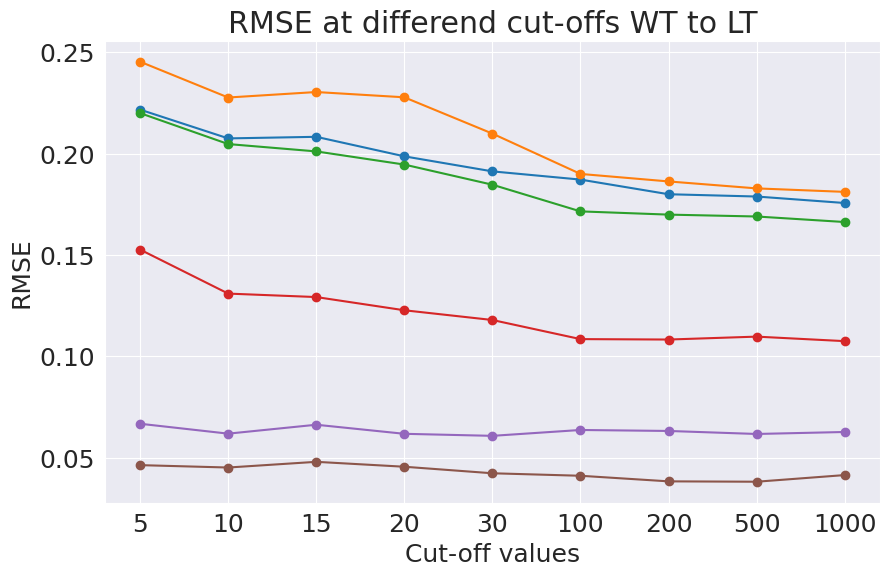

In [177]:
df = pd.DataFrame(df_content, index=cutoffs)
plt.figure()
ax = df.plot.line(style='o-', figsize=(10, 6))
ax.set_title("RMSE at differend cut-offs WT to LT")
ax.set_xlabel('Cut-off values')
ax.set_ylabel('RMSE')
ax.get_legend().remove()
plt.show()
ax.figure.savefig("../../MA/text/images/RMSE_WT-LT.png", dpi=300, bbox_inches='tight')

# KTAU plot

In [199]:
cutoffs = [200, 100, 50, 20, 10, 5]  # max 281

for WT, ST in zip(runs["WT"]["runs"].items(), runs["ST"]["runs"].items()):
    rpd_eval = RpdEvaluator(qrel_orig_path=runs["WT"]["qrel"]["path"],
                            run_b_orig_path=runs["WT"]["pivot"]["path"],
                            run_a_orig_path=WT[1]["path"],
                            run_b_rep_path=runs["ST"]["pivot"]["path"],
                            run_a_rep_path=ST[1]["path"],
    )
    for cutoff in cutoffs:
        rpd_eval.trim(t=cutoff)
        rpd_eval.evaluate()

        runs["ST"]["runs"][WT[0]]['ktu_' + str(cutoff)] = arp(rpd_eval.ktau_union()['advanced'])
        runs["ST"]["pivot"]['ktu_' + str(cutoff)] = arp(rpd_eval.ktau_union()['baseline'])

In [200]:
df_content = {}
for run_name in runs["ST"]["runs"]:
    df_content[run_name] = [runs["ST"]["runs"][run_name]['ktu_' + str(co)]for co in cutoffs[::-1]]

df_content["baseline"] = [runs["ST"]["pivot"]['ktu_' + str(co)] for co in cutoffs[::-1]]

<Figure size 640x480 with 0 Axes>

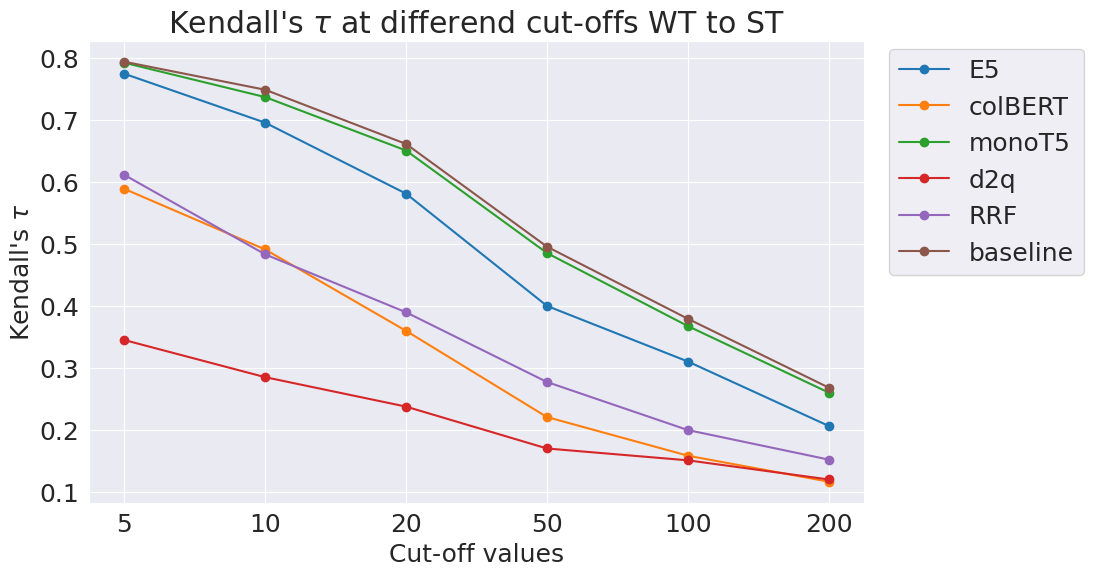

In [206]:
plt.figure()
ax = pd.DataFrame(data=df_content, index=[str(cutoff) for cutoff in cutoffs[::-1]]).plot(style='o-', figsize=(10, 6))
ax.set_xlabel('Cut-off values')
ax.set_title(r"Kendall's $\tau$ at differend cut-offs WT to ST")
ax.set_ylabel(r"Kendall's $\tau$")
ax.legend(bbox_to_anchor=(1.3, 1.01))
plt.show()
ax.figure.savefig("../../MA/text/images/ktau_WT-ST.png", dpi=300, bbox_inches='tight')

In [195]:
cutoffs = [200, 100, 50, 20, 10, 5]  # max 281

for WT, LT in zip(runs["WT"]["runs"].items(), runs["LT"]["runs"].items()):
    rpd_eval = RpdEvaluator(qrel_orig_path=runs["WT"]["qrel"]["path"],
                            run_b_orig_path=runs["WT"]["pivot"]["path"],
                            run_a_orig_path=WT[1]["path"],
                            run_b_rep_path=runs["LT"]["pivot"]["path"],
                            run_a_rep_path=ST[1]["path"])
    for cutoff in cutoffs:
        rpd_eval.trim(t=cutoff)
        rpd_eval.evaluate()

        runs["LT"]["runs"][WT[0]]['ktu_' + str(cutoff)] = arp(rpd_eval.ktau_union()['advanced'])
        runs["LT"]["pivot"]['ktu_' + str(cutoff)] = arp(rpd_eval.ktau_union()['baseline'])

In [196]:
df_content = {}
for run_name in runs["LT"]["runs"]:
    df_content[run_name] = [runs["LT"]["runs"][run_name]['ktu_' + str(co)]for co in cutoffs[::-1]]
    
df_content["baseline"] = [runs["LT"]["pivot"]['ktu_' + str(co)]for co in cutoffs[::-1]]

<Figure size 640x480 with 0 Axes>

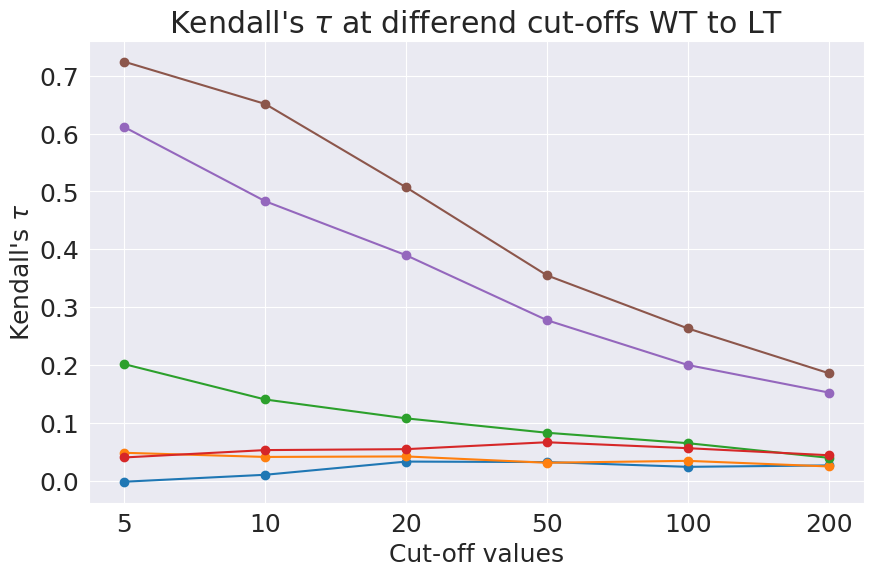

In [197]:
plt.figure()
ax = pd.DataFrame(data=df_content, index=[str(cutoff) for cutoff in cutoffs[::-1]]).plot(style='o-', figsize=(10, 6))
ax.set_xlabel('Cut-off values')
ax.set_ylabel(r"Kendall's $\tau$")
ax.set_title(r"Kendall's $\tau$ at differend cut-offs WT to LT")
ax.get_legend().remove()
plt.show()
ax.figure.savefig("../../MA/text/images/ktau_WT-LT.png", dpi=300, bbox_inches='tight')

# Table

In [135]:
# Per task tables
def make_table(slice):
    table = []
    measures=['P_20', 'ndcg', 'bpref']

    for measure in measures:
        for run in runs["WT"]["runs"].keys():
            rd_WTST = abs(runs["WT"]["runs"][run]["arp"][measure] - runs[slice]["runs"][run]["arp"][measure])
            table.append(
                {
                    "measure": measure,
                    "run": run,
                    "WT": runs["WT"]["runs"][run].get("arp", {}).get(measure),
                    slice: runs[slice]["runs"][run].get("arp", {}).get(measure),
                    "RD": rd_WTST,
                    "ER": runs[slice]["runs"][run].get("er",{}).get(measure),
                    "DRI": runs[slice]["runs"][run].get("dri",{}).get(measure),
                    "p-val": runs[slice]["runs"][run].get("pval",{}).get("advanced",{}).get(measure),
                    "RMSE": runs[slice]["runs"][run].get("rmse",{}).get("advanced",{}).get(measure),
                    r"Kendall's $\tau$": arp(runs[slice]["runs"][run].get("ktau",{}).get("advanced",{})),
                    "RBO": arp(runs[slice]["runs"][run].get("rbo",{}).get("advanced",{})),
                }
            )
        
        rd_WTST = abs(runs["WT"]["pivot"]["arp"][measure] - runs[slice]["pivot"]["arp"][measure])
        table.append(
            {
                "measure": measure,
                "run": "BM25",
                "WT": runs["WT"]["pivot"].get("arp", {}).get(measure),
                slice: runs[slice]["pivot"].get("arp", {}).get(measure),
                "RD": rd_WTST,
                r"Kendall's $\tau$": arp(runs[slice]["runs"][run].get("ktau",{}).get("baseline",{})),
                "RBO": arp(runs[slice]["runs"][run].get("rbo",{}).get("baseline",{})),
                "RMSE": runs[slice]["runs"][run].get("rmse",{}).get("baseline",{}).get(measure),
                "p-val": 1,
                "ER": 1,
                "DRI": 0,
            }
        )
    sorter = {"BM25": 0, "E5": 5, "colBERT": 2, "monoT5": 3, "d2q": 4, "RRF": 1}
    df = pd.DataFrame(table).round(3)
    df["sorter"] = df["run"].replace(sorter)
    df["measure"] = df["measure"].replace({"P_20": "P@20", "bpref": "Bpref", "ndcg":"nDCG"})
    df = df.sort_values(["measure", "sorter"]).drop("sorter", axis=1)
    df = df.set_index(["measure", "run"], drop=True)
    return df
    

In [136]:
table_st = make_table("ST")
table_st.to_latex("table_ST.tex", escape=False)
table_lt = make_table("LT")
table_lt.to_latex("table_LT.tex", escape=False)

/tmp/ipykernel_20767/4037811104.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_st.to_latex("table_ST.tex", escape=False)
/tmp/ipykernel_20767/4037811104.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_lt.to_latex("table_LT.tex", escape=False)


In [137]:
# full table
table = []
measures=['P_20', 'ndcg', 'bpref']

for measure in measures:
    for run in runs["WT"]["runs"].keys():
        rd_WTST = abs(runs["WT"]["runs"][run]["arp"][measure] - runs["ST"]["runs"][run]["arp"][measure])
        rd_WTLT = abs(runs["WT"]["runs"][run]["arp"][measure] - runs["LT"]["runs"][run]["arp"][measure])
        table.append(
            {
                "measure": measure,
                "run": run,
                "WT": runs["WT"]["runs"][run].get("arp", {}).get(measure),
                "ST": runs["ST"]["runs"][run].get("arp", {}).get(measure),
                "LT": runs["LT"]["runs"][run].get("arp", {}).get(measure),
                "RD(WT, ST)": rd_WTST,
                "RD(WT, LT)": rd_WTLT,
                "ER(WT, ST)": runs["ST"]["runs"][run].get("er",{}).get(measure),
                "ER(WT, LT)": runs["LT"]["runs"][run].get("er",{}).get(measure),
                "DRI(WT, ST)": runs["ST"]["runs"][run].get("dri",{}).get(measure),
                "DRI(WT, LT)": runs["LT"]["runs"][run].get("dri",{}).get(measure),
                "PVAL(WT, ST)": runs["ST"]["runs"][run].get("pval",{}).get("advanced",{}).get(measure),
                "PVAL(WT, LT)": runs["LT"]["runs"][run].get("pval",{}).get("advanced",{}).get(measure),
                "RMSE(WT, ST)": runs["ST"]["runs"][run].get("rmse",{}).get("advanced",{}).get(measure),
                "RMSE(WT, LT)": runs["LT"]["runs"][run].get("rmse",{}).get("advanced",{}).get(measure),
                "ktau@200(WT, ST)": arp(runs["ST"]["runs"][run].get("ktau",{}).get("advanced",{})),
                "ktau@200(WT, LT)": arp(runs["LT"]["runs"][run].get("ktau",{}).get("advanced",{})),
                "RBO(WT, ST)": arp(runs["ST"]["runs"][run].get("rbo",{}).get("advanced",{})),
                "RBO(WT, LT)": arp(runs["LT"]["runs"][run].get("rbo",{}).get("advanced",{})),
            }
        )
    
    rd_WTST = abs(runs["WT"]["pivot"]["arp"][measure] - runs["ST"]["pivot"]["arp"][measure])
    rd_WTLT = abs(runs["WT"]["pivot"]["arp"][measure] - runs["LT"]["pivot"]["arp"][measure])
    table.append(
        {
            "measure": measure,
            "run": "BM25",
            "WT": runs["WT"]["pivot"].get("arp", {}).get(measure),
            "ST": runs["ST"]["pivot"].get("arp", {}).get(measure),
            "LT": runs["LT"]["pivot"].get("arp", {}).get(measure),
            "RD(WT, ST)": rd_WTST,
            "RD(WT, LT)": rd_WTLT,
            "ktau@200(WT, ST)": arp(runs["ST"]["runs"][run].get("ktau",{}).get("baseline",{})),
            "ktau@200(WT, LT)": arp(runs["LT"]["runs"][run].get("ktau",{}).get("baseline",{})),
            "RBO(WT, ST)": arp(runs["ST"]["runs"][run].get("rbo",{}).get("baseline",{})),
            "RBO(WT, LT)": arp(runs["LT"]["runs"][run].get("rbo",{}).get("baseline",{})),
            "RMSE(WT, ST)": runs["ST"]["runs"][run].get("rmse",{}).get("baseline",{}).get(measure),
            "RMSE(WT, LT)": runs["LT"]["runs"][run].get("rmse",{}).get("baseline",{}).get(measure),
            "PVAL(WT, ST)": 1,
            "PVAL(WT, LT)": 1,
            "ER(WT, ST)": 1,
            "ER(WT, LT)": 1,
            "DRI(WT, ST)": 0,
            "DRI(WT, LT)": 0,
        }
    )

In [138]:
df = pd.DataFrame(table).round(3)

# sorting
custom_dict = {"BM25": 0, "E5": 5, "colBERT": 2, "monoT5": 3, "d2q": 4, "RRF": 1}
df["sorter"] = df["run"].replace(custom_dict)
df = df.sort_values(["measure", "sorter"]).drop("sorter", axis=1)
df = df.set_index(["measure", "run"], drop=True)

# multi index
df.columns = pd.MultiIndex.from_tuples([("ARP", "WT"), ("ARP", "ST"), ("ARP", "LT"), ("RD", "RD(WT, ST)"), ("RD", "RD(WT, LT)"), ("ER", "ER(WT, ST)"), ("ER", "ER(WT, LT)"), ("DRI", "DRI(WT, ST)"), ("DRI", "DRI(WT, LT)"), ("p-val", "PVAL(WT, ST)"), ("p-val", "PVAL(WT, LT)"), ("RMSE", "RMSE(WT, ST)"), ("RMSE", "RMSE(WT, LT)"), (r"Kendall's $\tau$", "ktau@200(WT, ST)"), (r"Kendall's $\tau$", "ktau@200(WT, LT)"), ("RBO", "RBO(WT, ST)"), ("RBO", "RBO(WT, LT)")])
df = df.rename(columns={"RD(WT, ST)": "WT, ST",  "RD(WT, LT)": "WT, LT",  "ER(WT, ST)": "WT, ST",  "ER(WT, LT)": "WT, LT",  "DRI(WT, ST)": "WT, ST",  "DRI(WT, LT)": "WT, LT",  "PVAL(WT, ST)": "WT, ST",  "PVAL(WT, LT)": "WT, LT",  "RMSE(WT, ST)": "WT, ST",  "RMSE(WT, LT)": "WT, LT",  "ktau@200(WT, ST)": "WT, ST",  "ktau@200(WT, LT)": "WT, LT",  "RBO(WT, ST)": "WT, ST",  "RBO(WT, LT)": "WT, LT"})

In [139]:
df

ARP                   RD            ER           DRI  \
                    WT     ST     LT WT, ST WT, LT WT, ST WT, LT WT, ST   
measure run                                                               
P_20    BM25     0.074  0.062  0.077  0.012  0.002  1.000  1.000  0.000   
        RRF      0.078  0.066  0.082  0.012  0.004  1.000  1.556  0.000   
        colBERT  0.073  0.065  0.075  0.008  0.002  0.500 -3.500 -0.011   
        monoT5   0.083  0.073  0.087  0.009  0.004  1.048  0.667 -0.006   
        d2q      0.081  0.069  0.081  0.012  0.000  1.176  0.824 -0.017   
        E5       0.073  0.062  0.079  0.011  0.006  1.000 -4.667  0.000   
bpref   BM25     0.311  0.301  0.329  0.010  0.018  1.000  1.000  0.000   
        RRF      0.349  0.316  0.351  0.033  0.002  1.053  0.768 -0.006   
        colBERT  0.337  0.313  0.339  0.024  0.001  0.648  1.017  0.031   
        monoT5   0.350  0.333  0.333  0.017  0.017  0.881  0.692  0.015   
        d2q      0.332  0.321  0.378  0.011  0.046  1.677  1.277 -0.046   
        E5       0.349  0.351  0.360  0.002  0.011  1.129  0.709 -0.015   
ndcg    BM25     0.286  0.264  0.310  0.022  0.024  1.000  1.000  0.000   
        RRF      0.311  0.282  0.321  0.029  0.011  1.013  0.645 -0.001   
        colBERT  0.289  0.271  0.296  0.018  0.007 -0.753  6.799  0.013   
        monoT5   0.314  0.303  0.312  0.011  0.002  0.869  0.529  0.013   
        d2q      0.294  0.277  0.334  0.016  0.040  1.584  1.975 -0.015   
        E5       0.297  0.294  0.314  0.003  0.017  1.235  1.399 -0.009   

                        p-val          RMSE        Kendall's $\tau$         \
                WT, LT WT, ST WT, LT WT, ST WT, LT           WT, ST WT, LT   
measure run                                                                  
P_20    BM25     0.000  1.000  1.000  0.006  0.015            0.268  0.186   
        RRF     -0.030  0.289  0.737  0.009  0.009            0.152  0.152   
        colBERT -0.102  0.418  0.843  0.006  0.051            0.117  0.025   
        monoT5   0.036  0.398  0.715  0.010  0.044            0.260  0.040   
        d2q      0.014  0.307  0.980  0.012  0.033            0.120  0.044   
        E5      -0.096  0.271  0.604  0.011  0.050            0.207  0.027   
bpref   BM25     0.000  1.000  1.000  0.032  0.099            0.268  0.186   
        RRF      0.030  0.420  0.897  0.096  0.096            0.152  0.152   
        colBERT  0.002  0.506  0.967  0.042  0.227            0.117  0.025   
        monoT5   0.042  0.663  0.647  0.032  0.208            0.260  0.040   
        d2q     -0.016  0.761  0.186  0.094  0.197            0.120  0.044   
        E5       0.039  0.959  0.751  0.045  0.298            0.207  0.027   
ndcg    BM25     0.000  1.000  1.000  0.013  0.041            0.268  0.186   
        RRF      0.030  0.386  0.707  0.063  0.063            0.152  0.152   
        colBERT -0.043  0.543  0.793  0.024  0.181            0.117  0.025   
        monoT5   0.048  0.737  0.944  0.020  0.166            0.260  0.040   
        d2q     -0.024  0.604  0.211  0.056  0.108            0.120  0.044   
        E5      -0.013  0.925  0.552  0.022  0.176            0.207  0.027   

                   RBO         
                WT, ST WT, LT  
measure run                    
P_20    BM25     0.952  0.931  
        RRF      0.874  0.874  
        colBERT  0.905  0.168  
        monoT5   0.949  0.649  
        d2q      0.817  0.454  
        E5       0.930  0.162  
bpref   BM25     0.952  0.931  
        RRF      0.874  0.874  
        colBERT  0.905  0.168  
        monoT5   0.949  0.649  
        d2q      0.817  0.454  
        E5       0.930  0.162  
ndcg    BM25     0.952  0.931  
        RRF      0.874  0.874  
        colBERT  0.905  0.168  
        monoT5   0.949  0.649  
        d2q      0.817  0.454  
        E5       0.930  0.162